In [1]:
#!/usr/bin/env python3
#import your libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier, Pool
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost import XGBClassifier

In [272]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

### Assigning columns to specific lists (cat, num, date, etc.)

In [273]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

Total columns: 220


In [357]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
#         self._correct_nan_value() #testing commenting out 
        for val in self.df_train.columns:
            total_null = np.sum(self.df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(self.df_train[val].dtype)
                self.list_unique_total.append(len(self.df_train[val].unique()))
                self.list_unique_val.append(self.df_train[val].unique())
                self.list_mode_value.append(self.df_train[val].mode()[0])
                val_counts = max(self.df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(self.df_train))
                val_unique = self.df_train[val].unique()
                self._create_dict(val_unique, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _correct_nan_value(self):
        '''correcting nan string values by converting to np.nan'''
        for col in self.df_train.columns:
            val_total_nan = self.df_train[self.df_train[col]=='nan']
            val_total_nan = val_total_nan.shape[0]
            if val_total_nan > 0:
                index_nan = self.df_train[self.df_train[col]=='nan']
                index_nan = index_nan.index 
                self.df_train.loc[index_nan, col] = np.nan
                
    def _create_dict(self, val_unique, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(self.df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(self.df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
#                 val_mode = self.df_train[val].mode()[0]
#                 self.df_train[val] = self.df_train[val].fillna(val_mode)
                if (val == 'P_emaildomain'):
                    self.df_train[val] = self.df_train[val].fillna('missing')
#                 if (val == 'addr1'):
#                     self.df_train[val] = self.df_train[val].fillna('0.0')
                else:
                    val_mode = self.df_train[val].mode()[0]
                    self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()

There were 195 columns with null values.


In [358]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

label encoded: addr1 unique 333
label encoded: addr2 unique 75
dummies encoded: ProductCD unique 5
label encoded: P_emaildomain unique 60
label encoded: card1 unique 13553
label encoded: card2 unique 501
label encoded: card3 unique 115
dummies encoded: card4 unique 4
label encoded: card5 unique 120
dummies encoded: card6 unique 4
dummies encoded: M1 unique 2
dummies encoded: M2 unique 2
dummies encoded: M3 unique 2
dummies encoded: M4 unique 3
dummies encoded: M6 unique 2
new dataframe shape:(590540, 228)


In [359]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

### Feature Engineering Class

In [360]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000]
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('after running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000]
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
        return df_feat
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe

    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1)
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1)
        print('dropping columns: ', self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        self._apply_df_transform(df_feat)
        self._create_tuning_df(df_feat)
        self.list_drop_col = []
        self._final_df_summary()
        
    def _shuffle_df(self, X, y):
        '''shuffle dataframe'''
        y = pd.Series(y)
        X = pd.DataFrame(X)
        df_temp = pd.concat([X, y], keys=['features','target'], axis=1)
        df_temp = shuffle(df_temp).reset_index(drop=True)
        X = df_temp.features
        y = df_temp.target
        return X, y
        
    def _final_df_summary(self):
        print("final dataframe created.")
        print("To test a model use the mod.create_df_score_model(model_current)")
        print("method where, for example, model_current = LogisticRegression().")

    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        X_train, X_test, y_train, y_test = self._split_dataframe(X, y)
        X_train, y_train = self._sampling_techniques(X_train, y_train)
        mod.X_train, mod.y_train = self._apply_pca(X_train, y_train)          # apply to train set
        mod.X_test , mod.y_test = self._apply_pca(X_test, y_test) 
        
    def _sampling_techniques(self, X_train, y_train):
        '''applying resampling techniques and shuffle'''
        X_train, y_train = self._apply_downsampling(X_train, y_train) # apply only train set
        X_train, y_train = self._apply_smote(X_train, y_train)
        X_train, y_train = self._shuffle_df(X_train, y_train)
        return X_train, y_train
    
    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            print("creating tuning dataframe...")
            X, y = self._drop_col_id_target(df_feat)
            X, y = self._apply_downsampling(X, y)
            X, y = self._apply_smote(X, y)
            mod.X_features, mod.y_target = self._shuffle_df(X, y)
        else:
            print('bool_create_tuning_df set to false.')

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.1, 
                                                            random_state=42)
        return X_train, X_test, y_train, y_test
        
    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_downsampling(self, X, y):
        '''down sampling majority class'''
        if bool_apply_downsampling:
            len_y_one = len(y[y==1])
            X_col_names = X.columns
            sampler = RandomUnderSampler(random_state=42, ratio={0:95000, 1:len_y_one})
            X, y = sampler.fit_sample(X, y)
            X = self._apply_col_names(X, X_col_names)
            print("downsampling applied.")
            return X, y
        else:
            print("bool_apply_downsampling set to false.")
            return X, y
            
    def _apply_smote(self, X, y):
        '''applying smote to split training set'''
        if bool_apply_smote:
            X_col_names = X.columns
            sm = SMOTE(random_state=42, n_jobs=-1)
            X, y = sm.fit_sample(X, y)
            X = self._apply_col_names(X, X_col_names)
            print("smote applied.")
            return X, y
        else:
            print("bool_apply_smote set to false.")
            return X, y
        
    def _apply_col_names(self, X, X_col_names):
        '''adding column names back to dataset'''
        X = pd.DataFrame(X, columns=X_col_names)
        return X
    
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X = self._pca(X)
            print('pca applied to training set, then test set.')
            return X, y
        else:
            print("bool_apply_pca set to false.")
            return X, y

    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca
        
    def _convert_to_matrix(self):
        '''converting X_test to matrix so columns match X_train'''
        if bool_apply_downsampling or bool_apply_smote:
            mod.X_test = pd.DataFrame(mod.X_test.values)
            
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if (col in df_features.columns):    
                self.list_drop_col.append(col) 
        else:
            print("keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        #del this method?
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values)
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if (non_fraud_total==0):
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat
    
mod = Model()
fe = FeatureEngineering()

bool_predict_proba = False
bool_thres_cost = False
bool_apply_pca = False
bool_apply_smote = True
bool_apply_downsampling = True

bool_create_tuning_df = True
bool_drop_col = True
df_feat_1000 = False
fe.final_features(bool_drop_col, list_feat=['addr1','addr2','card2','card3','C1','P_emaildomain', 
                                            'card6', 'V294','V279','C14','V306','D2','D10'])
bool_drop_col = False
fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1','D3','D4','D11'])
fe.list_drop_col.append('C4')
fe.create_final_df()


# testing - lines below are for testing
# df_feat_1000 = False
# fe.final_features(bool_drop_col, list_feat=['addr1'])
# fe.create_final_df()
# fe.feature_testing(bool_drop_col, list_feat=['addr1'])


after running final_features, run create_final_df.
after running final_features, run create_final_df.
keeping original feature card5
keeping original feature V317
keeping original feature V69
keeping original feature D1
keeping original feature D3
keeping original feature D4
keeping original feature D11
dropping columns:  ['addr1', 'addr2', 'card2', 'card3', 'C1', 'P_emaildomain', 'V294', 'V279', 'C14', 'V306', 'D2', 'D10', 'C4']
downsampling applied.
smote applied.
bool_apply_pca set to false.
bool_apply_pca set to false.
creating tuning dataframe...
downsampling applied.
smote applied.
final dataframe created.
To test a model use the mod.create_df_score_model(model_current)
method where, for example, model_current = LogisticRegression().


In [361]:
# save data
mod.X_train = pd.DataFrame(mod.X_train)
mod.y_train = pd.DataFrame(mod.y_train)
mod.X_test = pd.DataFrame(mod.X_test)
mod.y_test = pd.DataFrame(mod.y_test)
mod.X_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv')
mod.y_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv')
mod.X_test.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv')
mod.y_test.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv')
mod.X_features = pd.DataFrame(mod.X_features)
mod.y_target = pd.DataFrame(mod.y_target)
mod.X_features.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')


In [362]:
#read data
mod.X_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv').drop('Unnamed: 0',axis=1)
mod.y_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv').drop('Unnamed: 0',axis=1)
mod.X_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv').drop('Unnamed: 0',axis=1)
mod.y_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv').drop('Unnamed: 0',axis=1)
mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0',axis=1)
mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0',axis=1)

# mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0', axis=1)
# mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0', axis=1)
# mod.X_features.info(memory_usage='deep')
# mod.y_target.info(memory_usage='deep')


Fitting model:


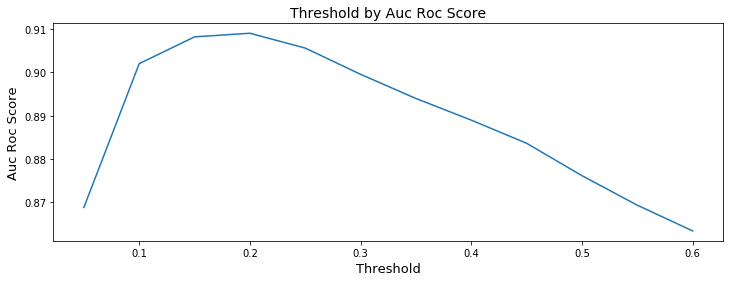

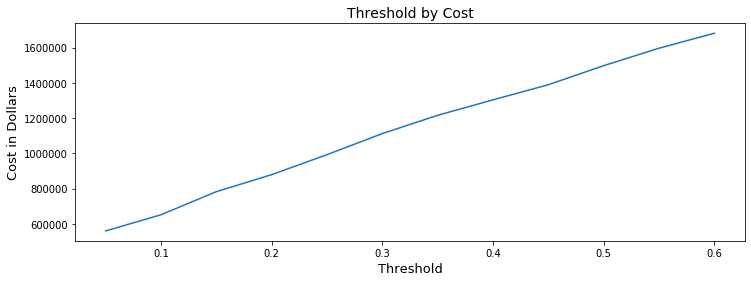

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.868820      559560  106  12078
1        0.10       0.902018      651220  174   6461
2        0.15       0.908199      782280  233   4164
3        0.20       0.909033      878780  273   2989
4        0.25       0.905608      992360  316   2218
5        0.30       0.899549     1111940  359   1747
6        0.35       0.893973     1215660  396   1383
7        0.40       0.888977     1303300  427   1115
8        0.45       0.883638     1389260  457    913
9        0.50       0.876157     1497320  494    766
10       0.55       0.869343     1596480  528    624
11       0.60       0.863399     1681360  557    518

roc auc score: 0.9090327606421159 


The following new features have been created: ['addr1_fe', 'addr2_fe', 'card2_fe', 'card3_fe', 'C1_fe', 'P_emaildomain_fe', 'card6_fe', 'V294_fe', 'V279_fe', 'C14_fe', 'V306_f

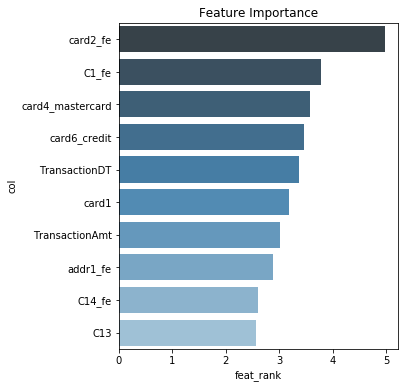

                 col  feat_rank
0           card2_fe   4.966792
1              C1_fe   3.772359
2   card4_mastercard   3.564812
3       card6_credit   3.463321
4      TransactionDT   3.363931
5              card1   3.186651
6     TransactionAmt   3.013023
7           addr1_fe   2.876496
8             C14_fe   2.605176
9                C13   2.566320
10               V95   2.452275
11  P_emaildomain_fe   2.435925
12                C2   2.431643
13              M6_T   2.309125
14           V294_fe   2.144322
15               C11   1.885106
16               V97   1.852050
17       card6_debit   1.614206
18           V279_fe   1.592800
19              V280   1.433463


In [363]:
# TUNED CatBoostClassifier 
# 0.906056md10 0.910956md11 score only filling addr1 with 0.0 for NaN values:

# final model will be md10, P_emaildomain with "missing"
# CURRENT we're going to go to fill P_emaildomain with missing
# 0.909033md10 0.9119md=11 score only filling P_emaildomain with "missing" for NaN values:
# 0.908418md11
# we fixed the nan values which changed our scores and feature ranking... 

# 0.907189md10 0.912185md11 score for neither
# 0.908655md10 0.909516 score both fillna addr1 p_emaildomain

bool_predict_proba = True
model_current = CatBoostClassifier(
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)


Fitting model:


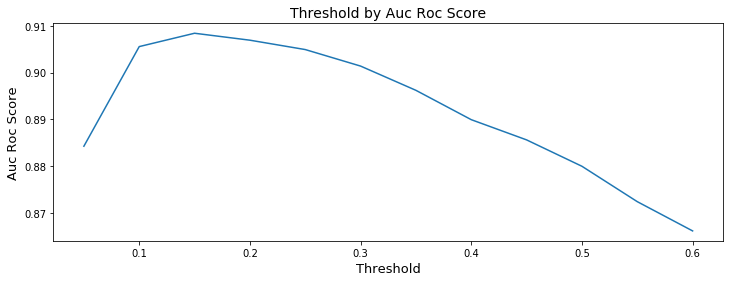

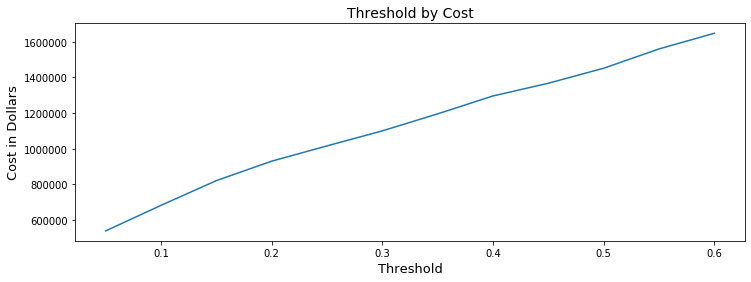

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.15 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.884282      539100  112  10155
1        0.10       0.905565      682500  190   5625
2        0.15       0.908418      821140  249   3707
3        0.20       0.906934      930300  292   2715
4        0.25       0.904932     1016040  325   2052
5        0.30       0.901402     1100340  356   1617
6        0.35       0.896221     1195780  390   1289
7        0.40       0.889952     1296160  425   1058
8        0.45       0.885632     1367500  450    875
9        0.50       0.879994     1451680  479    734
10       0.55       0.872434     1559920  516    596
11       0.60       0.866182     1647960  546    498

roc auc score: 0.9084183323306022 

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56945
           1       0.33      0.88      0.48      2109

    accurac

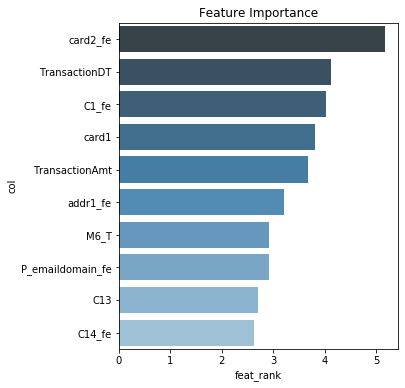

                 col  feat_rank
0           card2_fe   5.169321
1      TransactionDT   4.122691
2              C1_fe   4.023639
3              card1   3.811860
4     TransactionAmt   3.679857
5           addr1_fe   3.207189
6               M6_T   2.927795
7   P_emaildomain_fe   2.917269
8                C13   2.711793
9             C14_fe   2.627776
10          card6_fe   2.521201
11                C2   2.314731
12       ProductCD_W   2.311627
13        card4_visa   2.272290
14       card6_debit   1.992136
15           V306_fe   1.857512
16               V53   1.784784
17               V97   1.769311
18           V279_fe   1.746501
19             card5   1.708891


In [364]:
# bool_predict_proba = True
# model_current = CatBoostClassifier(
#                                    max_depth=11,
#                                    random_state=42, 
#                                    verbose=0)
# mod.create_df_score_model(model_current)

### Test Models

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)


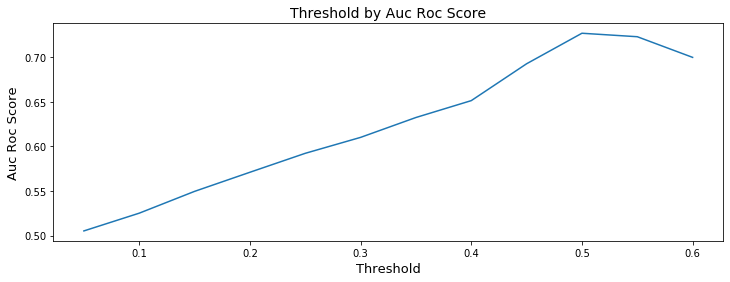

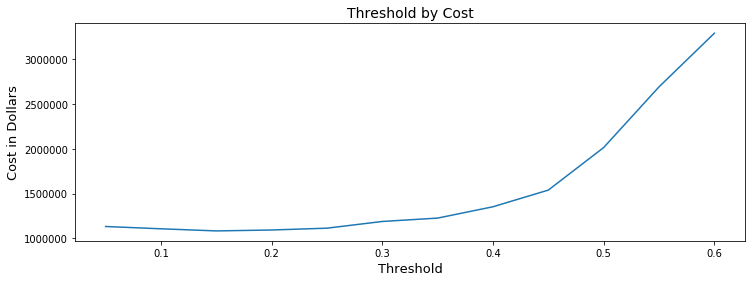

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.5 

threshold results dataframe:
     threshold  roc_auc_score  total_cost    fn     fp
0        0.05       0.505295     1131760     2  56288
1        0.10       0.525200     1106100    10  53805
2        0.15       0.549662     1082360    23  50668
3        0.20       0.571095     1092580    47  47579
4        0.25       0.592352     1113040    75  44402
5        0.30       0.610228     1187940   122  41097
6        0.35       0.632530     1225700   158  37585
7        0.40       0.651460     1352320   227  33566
8        0.45       0.692815     1538560   341  25778
9        0.50       0.727056     2014060   566  15803
10       0.55       0.723156     2692060   838   8903
11       0.60       0.699982     3290960  1060   5548

roc auc score: 0.7270564865460217 

              precision    recall  f1-score   support

           0       0.99      0.72      0.83     56945
           1       0.09      0.73      0.16      2109


In [365]:
# BASE LogisticRegression
bool_predict_proba = True
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=150,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                   warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=150,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                   warm_start=False)


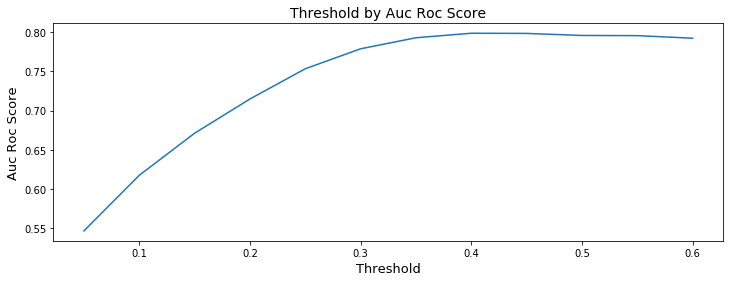

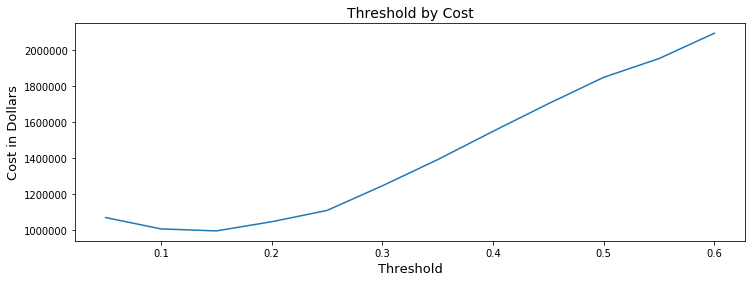

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.4 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.546861     1071520   16  51176
1        0.10       0.617587     1008820   56  42041
2        0.15       0.671129      997560  101  34728
3        0.20       0.714679     1048420  162  28121
4        0.25       0.753128     1110900  223  22095
5        0.30       0.778547     1247340  302  17067
6        0.35       0.792595     1392460  374  13523
7        0.40       0.798337     1549120  443  11006
8        0.45       0.798108     1702160  505   9358
9        0.50       0.795526     1848260  562   8113
10       0.55       0.795289     1952120  604   7006
11       0.60       0.792039     2092360  658   5918

roc auc score: 0.7983368153102569 

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     56945
           1       0.13      0.79      0.23      2109

    accuracy

In [380]:
# RERUN with updated tuned model
# TUNED LogisticRegression
bool_predict_proba = True
model_current =  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                    intercept_scaling=0.1, l1_ratio=0.01, max_iter=150,
                                    multi_class='auto', n_jobs=-1, penalty='none',
                                    random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                                    warm_start=False)

mod.create_df_score_model(model_current)


Fitting model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


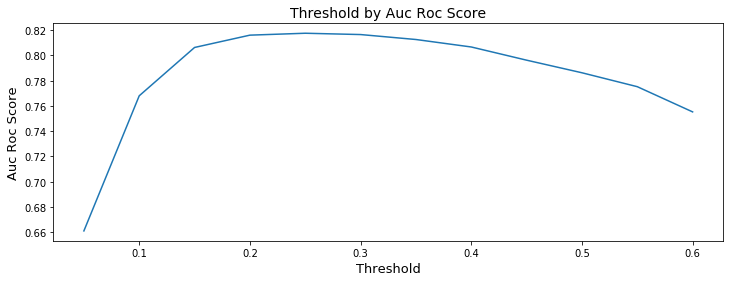

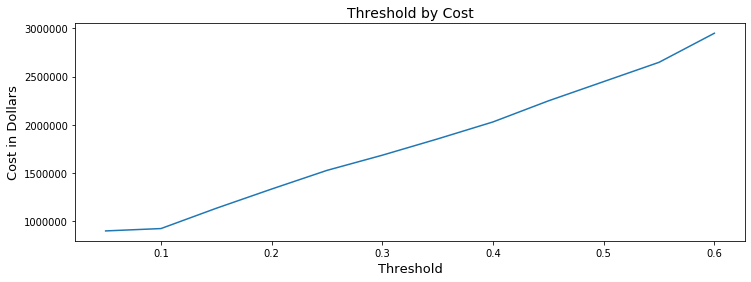

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.660997      900100   52  37205
1        0.10       0.768020      924460  161  22073
2        0.15       0.806302     1134920  282  14446
3        0.20       0.816056     1334100  372  10905
4        0.25       0.817566     1527460  452   8573
5        0.30       0.816529     1684800  515   6990
6        0.35       0.812604     1853640  580   5682
7        0.40       0.806685     2029480  646   4574
8        0.45       0.796236     2247620  725   3631
9        0.50       0.786261     2447460  797   2823
10       0.55       0.775241     2647220  868   2161
11       0.60       0.755273     2948540  972   1627

roc auc score: 0.8175658210627317 

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     56945
           1       0.16      0.79      0.27      2109

    accurac

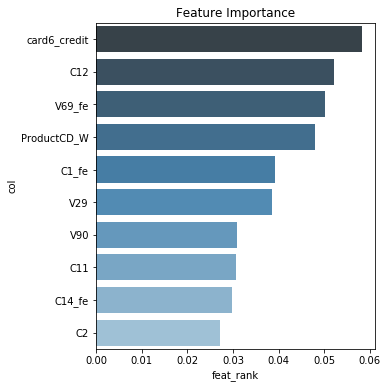

                 col  feat_rank
0       card6_credit   0.058194
1                C12   0.052210
2             V69_fe   0.050157
3        ProductCD_W   0.047867
4              C1_fe   0.039166
5                V29   0.038663
6                V90   0.030819
7                C11   0.030758
8             C14_fe   0.029865
9                 C2   0.027212
10          card2_fe   0.025694
11               V97   0.024034
12              V103   0.023632
13           V317_fe   0.022870
14              V102   0.022753
15  card4_mastercard   0.022664
16           V294_fe   0.022061
17                C6   0.021529
18              V282   0.021376
19                C8   0.020472


In [367]:
# BASE XGBClassifier
bool_predict_proba = True
model_current = XGBClassifier(n_jobs=-1,random_state=42)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)
XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


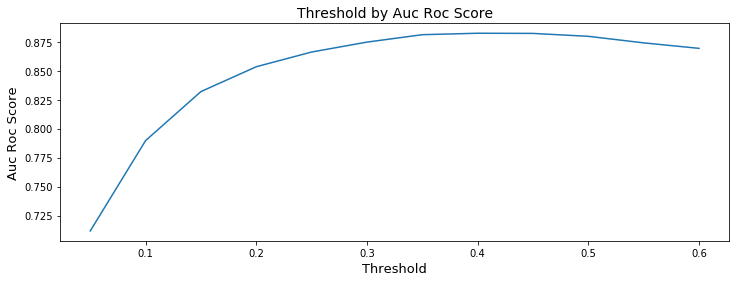

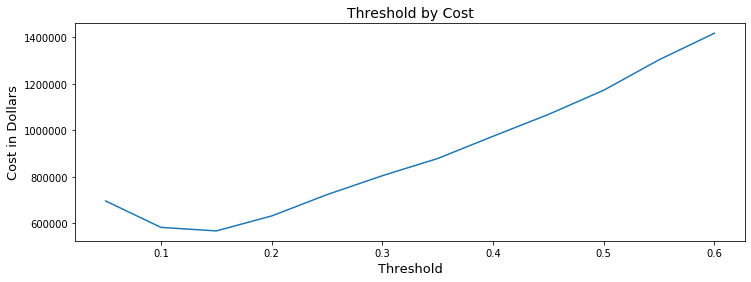

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.4 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.711766      695900   16  32395
1        0.10       0.789709      582320   42  22816
2        0.15       0.832004      567160   75  17108
3        0.20       0.853428      631520  121  13426
4        0.25       0.866133      723120  170  10656
5        0.30       0.874684      804500  211   8575
6        0.35       0.881076      878500  247   6875
7        0.40       0.882331      974040  287   5652
8        0.45       0.882191     1067840  325   4642
9        0.50       0.879679     1171960  365   3848
10       0.55       0.874033     1302900  413   3195
11       0.60       0.869291     1417020  455   2601

roc auc score: 0.8823314411545902 

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     56945
           1       0.24      0.86      0.38      2109

    accuracy

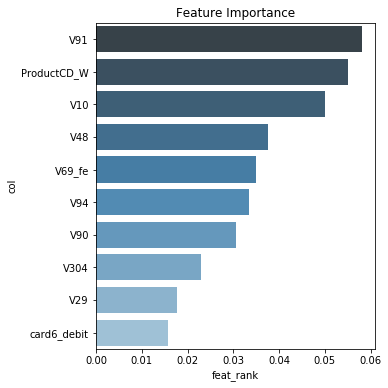

            col  feat_rank
0           V91   0.058035
1   ProductCD_W   0.055148
2           V10   0.049943
3           V48   0.037612
4        V69_fe   0.035055
5           V94   0.033531
6           V90   0.030495
7          V304   0.022845
8           V29   0.017685
9   card6_debit   0.015698
10          V34   0.014265
11          V57   0.013957
12         V302   0.013181
13          V70   0.013053
14         V303   0.012761
15     card6_fe   0.012661
16     card3_fe   0.011382
17      V317_fe   0.010660
18       C14_fe   0.010146
19          C11   0.009917


In [368]:
# TUNED XGBClassifier n_estimators=150
bool_predict_proba = True
model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
                              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
                              nthread=None, objective='binary:logistic', random_state=42,
                              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
                              silent=None, subsample=0.5, verbosity=1)
mod.create_df_score_model(model_current)

Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


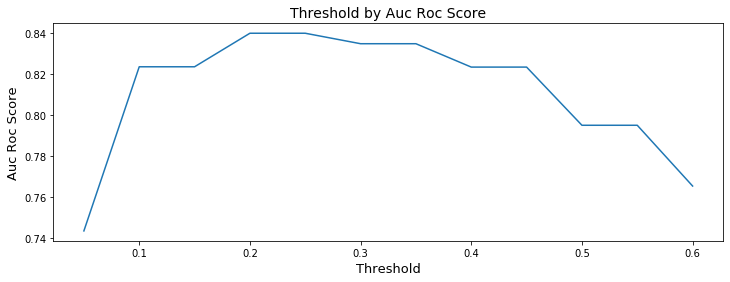

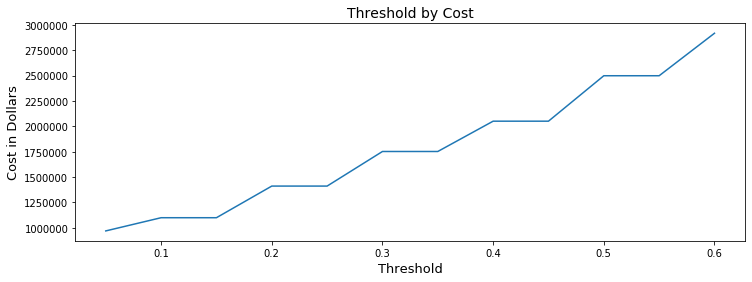

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.743418      968200  156  25010
1        0.10       0.823389     1098460  283  12473
2        0.15       0.823389     1098460  283  12473
3        0.20       0.839728     1410560  425   6778
4        0.25       0.839728     1410560  425   6778
5        0.30       0.834625     1751820  559   3741
6        0.35       0.834625     1751820  559   3741
7        0.40       0.823236     2050820  670   2041
8        0.45       0.823236     2050820  670   2041
9        0.50       0.794892     2499140  826   1057
10       0.55       0.794892     2499140  826   1057
11       0.60       0.765283     2918360  969    568

roc auc score: 0.8397277808884576 

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     56945
           1       0.20      0.80      0.32      2109

    accuracy

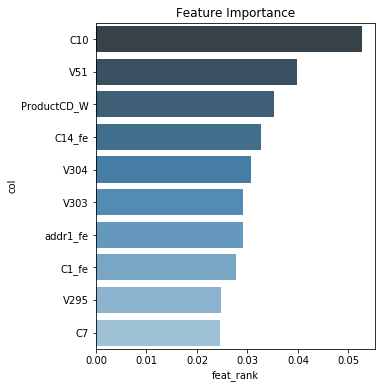

               col  feat_rank
0              C10   0.052613
1              V51   0.039900
2      ProductCD_W   0.035291
3           C14_fe   0.032731
4             V304   0.030636
5             V303   0.029113
6         addr1_fe   0.029096
7            C1_fe   0.027759
8             V295   0.024764
9               C7   0.024604
10              C2   0.023622
11        card2_fe   0.022319
12            V102   0.021236
13             V52   0.020222
14             V30   0.018541
15   TransactionDT   0.017812
16  TransactionAmt   0.017236
17             C11   0.014799
18            V283   0.013354
19            V308   0.013280


In [373]:
# BASE RandomForestClassifier
bool_predict_proba = True
model_current = RandomForestClassifier(n_jobs=-1, random_state=42)
mod.create_df_score_model(model_current)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.7s finished


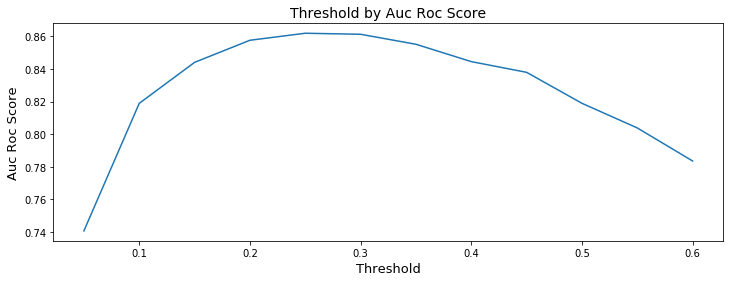

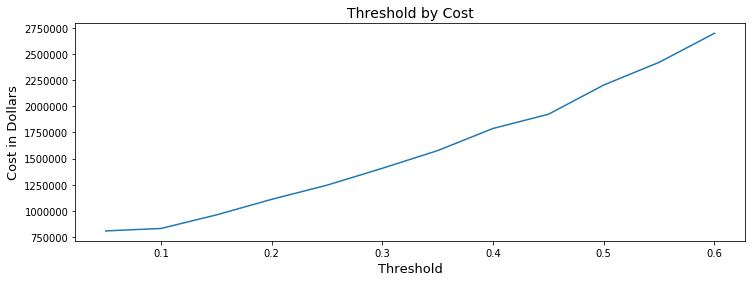

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.740617      809760   89  27138
1        0.10       0.818876      833220  171  16011
2        0.15       0.844049      962840  247  11092
3        0.20       0.857606     1111540  320   7577
4        0.25       0.861916     1246860  379   5493
5        0.30       0.861284     1408200  444   3810
6        0.35       0.855154     1577140  507   2807
7        0.40       0.844512     1788340  583   1967
8        0.45       0.837935     1923860  632   1393
9        0.50       0.818924     2203320  728    966
10       0.55       0.803813     2419780  802    689
11       0.60       0.783521     2697240  896    462

roc auc score: 0.8619162401260547 

              precision    recall  f1-score   support

           0       0.99      0.90      0.95     56945
           1       0.24      0.82      0.37      2109

    accurac

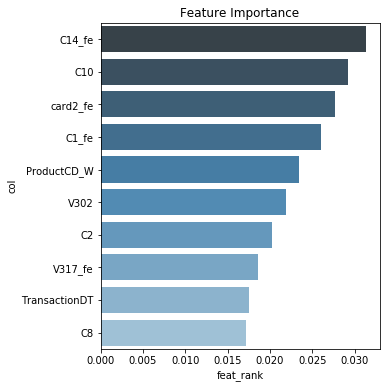

               col  feat_rank
0           C14_fe   0.031386
1              C10   0.029249
2         card2_fe   0.027741
3            C1_fe   0.026060
4      ProductCD_W   0.023465
5             V302   0.021914
6               C2   0.020195
7          V317_fe   0.018640
8    TransactionDT   0.017577
9               C8   0.017159
10             C13   0.015993
11         V294_fe   0.015720
12  TransactionAmt   0.015550
13         V306_fe   0.015165
14            V317   0.014196
15             C11   0.013957
16        addr1_fe   0.013446
17     card6_debit   0.013277
18            V303   0.012814
19        card3_fe   0.012612


In [374]:
# TUNED RandomForestClassifier
bool_predict_proba = True
model_current = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0, n_estimators=150,
                                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                                       warm_start=False)

mod.create_df_score_model(model_current)


Fitting model:


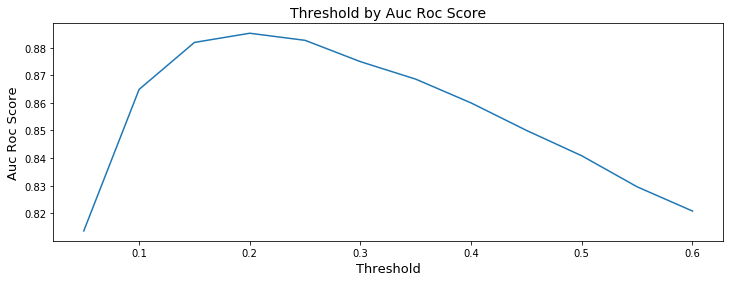

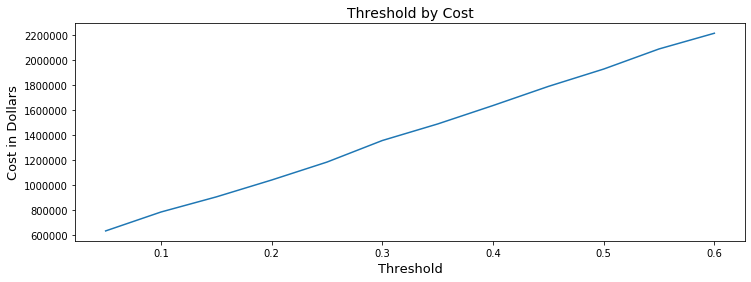

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.813609      631200   84  18960
1        0.10       0.864877      782560  193  10178
2        0.15       0.881901      903680  258   6484
3        0.20       0.885229     1038780  316   4539
4        0.25       0.882656     1182400  372   3320
5        0.30       0.874928     1354980  435   2499
6        0.35       0.868588     1487500  483   1925
7        0.40       0.859974     1635040  535   1502
8        0.45       0.850026     1788080  588   1204
9        0.50       0.840824     1927120  636    956
10       0.55       0.829584     2088020  691    751
11       0.60       0.820812     2213780  734    589

roc auc score: 0.8852287323901207 

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     56945
           1       0.28      0.85      0.42      2109

    accuracy

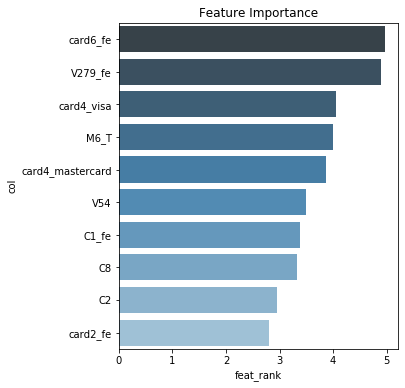

                 col  feat_rank
0           card6_fe   4.960817
1            V279_fe   4.893808
2         card4_visa   4.056614
3               M6_T   3.990590
4   card4_mastercard   3.869905
5                V54   3.491150
6              C1_fe   3.383268
7                 C8   3.318816
8                 C2   2.947850
9           card2_fe   2.806247
10            C14_fe   2.780501
11           V306_fe   2.593352
12           V294_fe   2.577023
13               V75   2.525938
14               C13   2.432648
15              V312   2.332073
16      card6_credit   2.302480
17               V95   1.796225
18       ProductCD_W   1.739063
19               V96   1.513298


In [376]:
# BASE CatBoostClassifier 
bool_predict_proba = True
model_current = CatBoostClassifier(random_state=42, verbose=0)
mod.create_df_score_model(model_current)

# Model Class

In [5]:
class Model():
    def __init__(self):
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        self.dict_results = {'index':[0], 'threshold':[], 'roc_auc_score':[], 
                             'total_cost':[], 'fn':[], 'fp':[]}
        self.X_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv').drop('Unnamed: 0',axis=1)
        self.y_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv').drop('Unnamed: 0',axis=1)
        self.X_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv').drop('Unnamed: 0',axis=1)
        self.y_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv').drop('Unnamed: 0',axis=1)
        self.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0',axis=1)
        self.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0',axis=1)
        
    def create_df_score_model(self, model):
        '''scores model'''
        print("Fitting model:\n", model)
        y_pred, elapsed_time, model = self.add_model(model) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred, model = self._predict(model)
        bool_predict_proba = False
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time, model
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            print(model)
            y_pred, model = self._predict_proba(model)
            y_pred = self._predict_proba_threshold(y_pred)
            return y_pred, model
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred, model
        
    def _predict_proba(self, model):
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            return y_pred_prob, model
        except:
            print("Model does not have predict_proba attribute.")

    def _predict_proba_threshold(self, y_pred):
        '''create prediction for each threshold'''
        df_results = pd.DataFrame()
        list_threshold = [.05, .1, .15, .2, .25, .3, 
                          .35, .4, .45, .5, .55, .6]
        for threshold in list_threshold:
            df_temp = self._compute_thres_df(y_pred, threshold)
            df_results = pd.concat([df_results, df_temp], axis=0)
        df_results = df_results.drop('index', axis=1).reset_index(drop=True)
        val_thres_cost, val_thres_auc = self._calc_and_plot_results(df_results)
        y_pred_class = self._y_pred_class(y_pred, val_thres_cost, val_thres_auc)
        print('threshold results dataframe:\n', df_results)
        return y_pred_class
        
    def _compute_thres_df(self, y_pred_prob, threshold):
        '''compute the values for each threshold'''
        y_pred_class = binarize(y_pred_prob, threshold)[:,1]
        df_conf_matrix = self._compute_conf_matrix(y_pred_class)
        df_dict_results = self._compute_results(df_conf_matrix, y_pred_class, threshold)
        return df_dict_results
    
    def _compute_conf_matrix(self, y_pred_class):
        '''compute the confusion matrix for the current threshold'''
        conf_matr = confusion_matrix(self.y_test, y_pred_class)
        df_conf_matrix = pd.DataFrame(conf_matr)
        return df_conf_matrix
    
    def _compute_results(self, df_conf_matrix, y_pred_class, threshold):
        '''compute results for each threshold and save to dictionary'''
        val_fn = df_conf_matrix[0][1]
        val_fp = df_conf_matrix[1][0]
        val_cost = 3000*val_fn + 20*val_fp
        val_score = roc_auc_score(self.y_test, y_pred_class)
        self.dict_results.update([('threshold', threshold)])
        self.dict_results.update([('roc_auc_score', val_score)])
        self.dict_results.update([('total_cost', val_cost)])
        self.dict_results.update([('fn', val_fn)])
        self.dict_results.update([('fp', val_fp)])
        df_dict_results = pd.DataFrame.from_dict(self.dict_results)
        return df_dict_results
    
    def _calc_and_plot_results(self, df_results):
        '''plot results and calculate best threshold for auc and cost'''
        self._plot_thres_auc(df_results)
        self._plot_thres_score(df_results)
        val_thres_cost = self._calc_best_thres_cost(df_results)
        val_thres_auc = self._calc_best_thres_auc(df_results)
        return val_thres_cost, val_thres_auc
        
    def _plot_thres_auc(self, df_results):
        '''plot auc roc score by threshold'''
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Auc Roc Score", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Auc Roc Score", fontsize=13)
        plt.plot('threshold', 'roc_auc_score', data=df_results)
        plt.show()

    def _plot_thres_score(self, df_results):
        '''plot cost by threshold'''
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Cost", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Cost in Dollars", fontsize=13)
        plt.plot('threshold', 'total_cost', data=df_results)
        plt.show()
    
    def _calc_best_thres_cost(self, df_results):
        '''calculate the best threshold by cost'''
        val_min_cost = df_results.total_cost.min()
        index_min_cost = df_results[df_results.total_cost==val_min_cost].index[0]
        val_threshold_min_cost = df_results.loc[index_min_cost,:].threshold.item()
        print("Best threshold by cost:", val_threshold_min_cost)
        return val_threshold_min_cost

    def _calc_best_thres_auc(self, df_results):
        '''calculate the best threshold by highest auc roc score'''
        val_max_roc_auc = df_results.roc_auc_score.max()
        index_max_roc_auc = df_results[df_results.roc_auc_score==val_max_roc_auc].index[0]
        val_threshold_roc_auc = df_results.loc[index_max_roc_auc,:].threshold.item()
        print("Best threshold by roc auc score:", val_threshold_roc_auc, '\n')
        return val_threshold_roc_auc
    
    def _y_pred_class(self, y_pred_prob, val_thres_cost, val_thres_auc):
        '''calculate y_pred_class depending on if we want cost or auc threshold'''
        if bool_thres_cost:
            y_pred_class = binarize(y_pred_prob, val_thres_cost)[:,1]
            return y_pred_class
        else:
            y_pred_class = binarize(y_pred_prob, val_thres_auc)[:,1]
            return y_pred_class

    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time, col_auc = self._calc_scores(y_pred, 
                                                                         elapsed_time) 
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_auc, col_recall, col_precision, 
                             df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_auc = pd.Series(roc_auc_score(mod.y_test, y_pred), name='roc_auc_score')
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print('\nroc auc score:', roc_auc_score(mod.y_test, y_pred), '\n')
        return col_recall, col_precision, col_time, col_auc
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:", fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print(classif_report)
        print('\ndf_scores:\n\n', df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            self._feat_import_method(model)
        except:
            print("\nmodel does not have _feature_importance attribute.")
    
    def _feat_import_method(self, model):
        '''run feature importance methods'''
        df_feat_rank = self._feat_import_create_df(model)
        df_feat_rank = self._feat_import_create_plot(df_feat_rank)
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(mod.X_train.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank.reset_index(drop=True)
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        plt.figure(figsize=(5,6))
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        print(df_feat_rank[0:20])
        
mod = Model()


In [ ]:
# iterations=300
iterations = [100,200,300]
for val in iterations:
    model_current = CatBoostClassifier(random_state=42, iterations=val, verbose=0, 
                                       max_depth=9)
    mod.create_df_score_model(model_current)

In [ ]:
# bagging_temperature=1e-3, 0.8849
# bagging_temperature, n_estimators,  
bagging_temperature = [1e-1,1e-2,1e-3]
for val in iterations:
    model_current = CatBoostClassifier(random_state=42, bagging_temperature=val, verbose=0)
    mod.create_df_score_model(model_current)

In [ ]:
# bootstrap_type = 'Bernoulli' 0.886326
bootstrap_type = ['Bayesian', 'Bernoulli', 'MVS', None]
for val in bootstrap_type:
#     print(val+'\n')
    model_current = CatBoostClassifier(random_state=42, bootstrap_type=val, verbose=0)
    mod.create_df_score_model(model_current)

In [ ]:
# boosting_type = 'Plain' 0.884913
boosting_type = ['Ordered', 'Plain']
for val in boosting_type:
    print(val+'\n')
    model_current = CatBoostClassifier(random_state=42, boosting_type=val, verbose=0)
    mod.create_df_score_model(model_current)

In [ ]:
# grow_policy = ['SymmetricTree', 'Depthwise']
# for val in grow_policy:
#     print(val+'\n')
#     model_current = CatBoostClassifier(random_state=42, grow_policy=val, verbose=0)
#     mod.create_df_score_model(model_current)

In [ ]:
# min_child_samples = [2,3,4]
# for val in min_child_samples:
#     print(val)
#     model_current = CatBoostClassifier(random_state=42, min_child_samples=val, verbose=0)
#     mod.create_df_score_model(model_current)

In [ ]:
# max_leaves = [2,3,4]
# for val in max_leaves:
#     print(val)
#     model_current = CatBoostClassifier(random_state=42, max_leaves=val, verbose=0)
#     mod.create_df_score_model(model_current)

In [ ]:
# colsample_bylevel = .1 best? 0.884395
colsample_bylevel = [1e-1,1e-2,1e-3,.2,.5,.9]
colsample_bylevel = [.1,.2,.3]
for val in colsample_bylevel:
    print(val)
    model_current = CatBoostClassifier(random_state=42, colsample_bylevel=val, verbose=0)
    mod.create_df_score_model(model_current)

In [ ]:
# RERUN when you have a moment. 
# subsample = .4
# subsample = [1e-1,1e-2,1e-3]
# subsample = [.1,.2,.3,.4]
subsample = [.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]
for val in subsample:
    print(val)
    model_current = CatBoostClassifier(random_state=42, subsample=val, verbose=0)
    mod.create_df_score_model(model_current)

Fitting model:


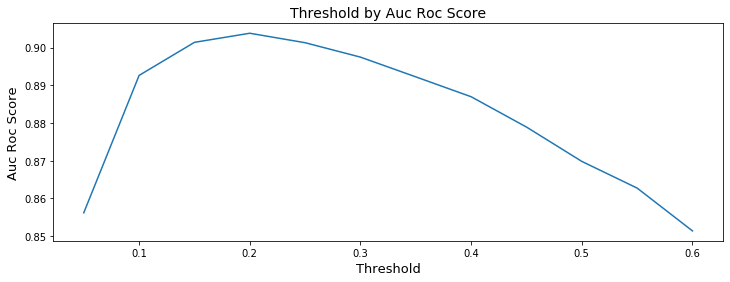

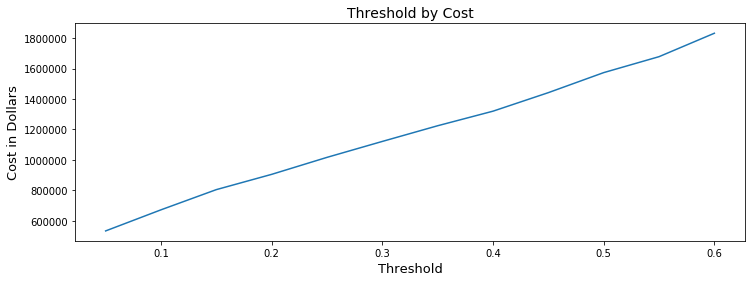

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.856203      534180   84  14109
1        0.10       0.892623      672620  174   7531
2        0.15       0.901385      805180  236   4859
3        0.20       0.903800      905460  279   3423
4        0.25       0.901288     1016960  322   2548
5        0.30       0.897468     1121600  361   1930
6        0.35       0.892235     1224540  398   1527
7        0.40       0.886966     1320180  432   1209
8        0.45       0.878932     1441800  474    990
9        0.50       0.869826     1573240  519    812
10       0.55       0.862749     1677920  555    646
11       0.60       0.851395     1831700  607    535

roc auc score: 0.9037995910056208 


The following new features have been created: ['addr1_fe', 'addr2_fe', 'card2_fe', 'card3_fe', 'C1_fe', 'P_emaildomain_fe', 'card6_fe', 'V294_fe', 'V279_fe', 'C14_fe', 'V306_f

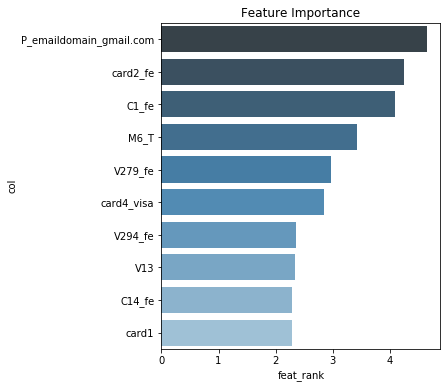

                        col  feat_rank
0   P_emaildomain_gmail.com   4.656434
1                  card2_fe   4.243194
2                     C1_fe   4.090005
3                      M6_T   3.418353
4                   V279_fe   2.966773
5                card4_visa   2.853815
6                   V294_fe   2.354405
7                       V13   2.335893
8                    C14_fe   2.291513
9                     card1   2.290404
10            TransactionDT   2.265565
11           TransactionAmt   2.207124
12                 addr1_fe   2.191637
13              card6_debit   2.071744
14                       C2   1.992660
15              ProductCD_W   1.990797
16                      C13   1.951870
17                      V96   1.838520
18                  V306_fe   1.643107
19                      V95   1.443103
Fitting model:


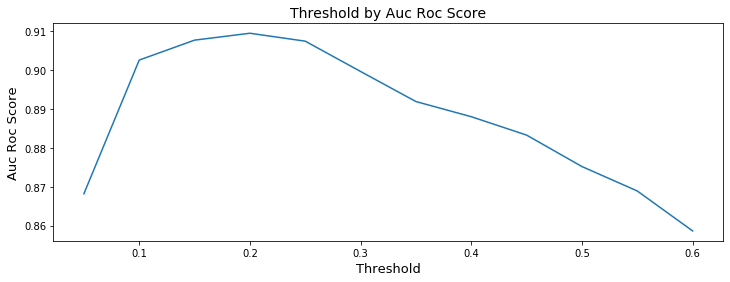

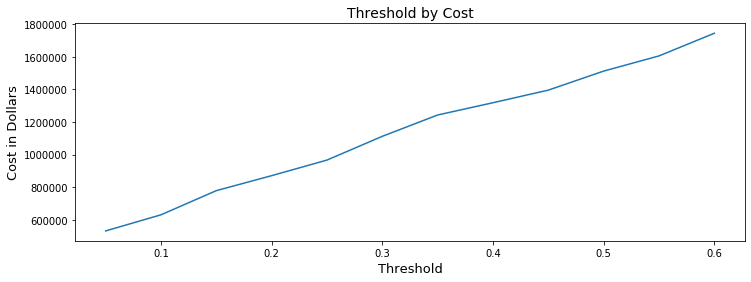

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.868179      531500   94  12475
1        0.10       0.902571      630280  166   6614
2        0.15       0.907698      778500  231   4275
3        0.20       0.909472      870400  270   3020
4        0.25       0.907434      966060  307   2253
5        0.30       0.899637     1111740  359   1737
6        0.35       0.891901     1242520  405   1376
7        0.40       0.888002     1317820  432   1091
8        0.45       0.883270     1395020  459    901
9        0.50       0.875182     1511840  499    742
10       0.55       0.868895     1604880  531    594
11       0.60       0.858622     1743900  578    495

roc auc score: 0.9094718057290438 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56945
           1       0.38      0.87      0.53      2109

    accuracy

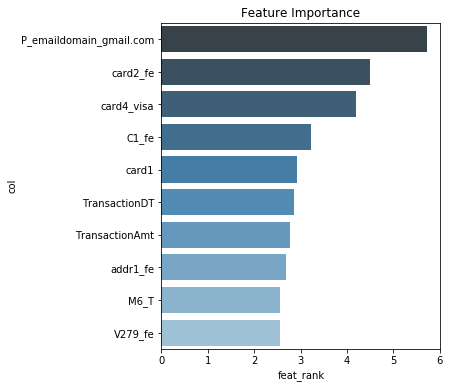

                        col  feat_rank
0   P_emaildomain_gmail.com   5.728647
1                  card2_fe   4.490900
2                card4_visa   4.201418
3                     C1_fe   3.221476
4                     card1   2.923953
5             TransactionDT   2.847223
6            TransactionAmt   2.772896
7                  addr1_fe   2.690843
8                      M6_T   2.554771
9                   V279_fe   2.553516
10                   C14_fe   2.500072
11                      C13   2.454294
12                      V97   2.281153
13                       C2   2.150315
14                      V95   1.939679
15                  V294_fe   1.902664
16                 card6_fe   1.890968
17         card4_mastercard   1.890838
18             card6_credit   1.791092
19                  V306_fe   1.688621
Fitting model:


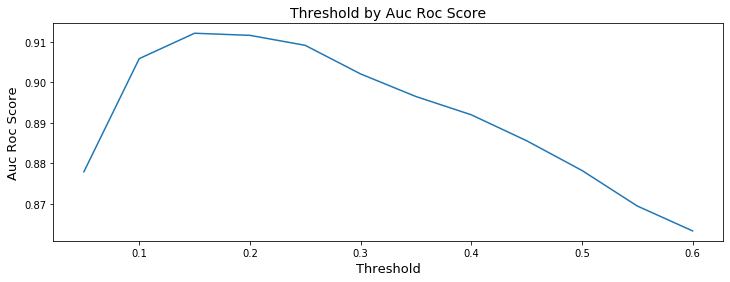

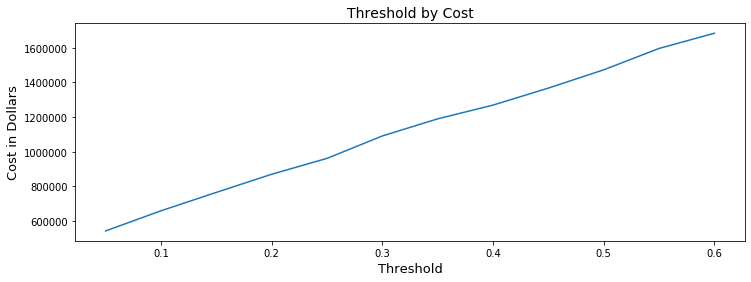

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.15 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.877908      543780  108  10989
1        0.10       0.905820      659780  181   5839
2        0.15       0.912089      766040  230   3802
3        0.20       0.911570      870540  272   2727
4        0.25       0.909103      962260  307   2063
5        0.30       0.902052     1091480  353   1624
6        0.35       0.896476     1190280  388   1314
7        0.40       0.891971     1269420  416   1071
8        0.45       0.885570     1367640  450    882
9        0.50       0.878238     1472900  486    745
10       0.55       0.869466     1596200  528    610
11       0.60       0.863320     1684000  558    500

roc auc score: 0.912088698631577 

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56945
           1       0.33      0.89      0.48      2109

    accuracy

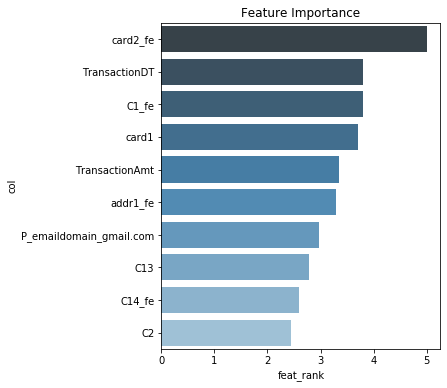

                        col  feat_rank
0                  card2_fe   5.011202
1             TransactionDT   3.807281
2                     C1_fe   3.792985
3                     card1   3.700149
4            TransactionAmt   3.349901
5                  addr1_fe   3.282719
6   P_emaildomain_gmail.com   2.965988
7                       C13   2.774734
8                    C14_fe   2.586358
9                        C2   2.439811
10                     M6_T   2.399338
11               card4_visa   2.203424
12                  V306_fe   2.123856
13         card4_mastercard   1.909662
14                      V75   1.903117
15                  V294_fe   1.897588
16                 card6_fe   1.722351
17              ProductCD_W   1.635572
18             card6_credit   1.606335
19                    card5   1.583425
Fitting model:


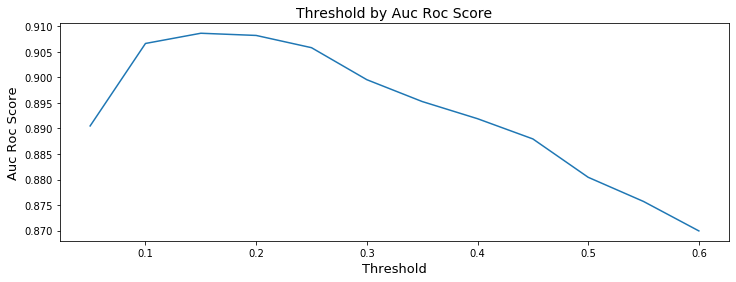

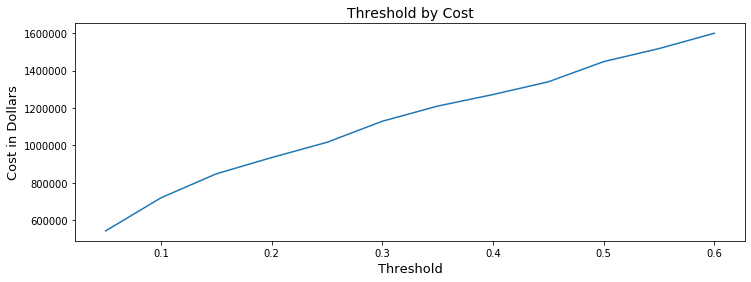

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.15 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn    fp
0        0.05       0.890490      542180  119  9259
1        0.10       0.906645      719400  206  5070
2        0.15       0.908647      847680  260  3384
3        0.20       0.908216      934760  295  2488
4        0.25       0.905819     1016480  326  1924
5        0.30       0.899549     1129160  366  1558
6        0.35       0.895273     1210240  395  1262
7        0.40       0.891910     1272020  417  1051
8        0.45       0.887950     1340080  441   854
9        0.50       0.880433     1448220  478   711
10       0.55       0.875700     1518040  502   602
11       0.60       0.869931     1600060  530   503

roc auc score: 0.9086465311936796 

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56945
           1       0.35      0.88      0.50      2109

    accuracy            

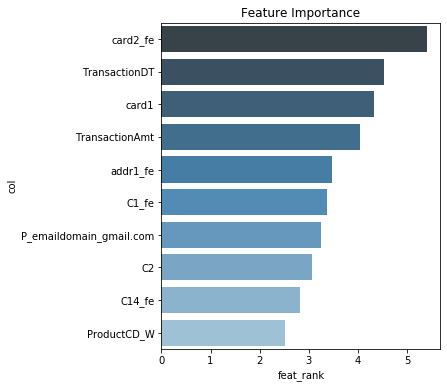

                        col  feat_rank
0                  card2_fe   5.411206
1             TransactionDT   4.526731
2                     card1   4.330261
3            TransactionAmt   4.050926
4                  addr1_fe   3.465538
5                     C1_fe   3.367102
6   P_emaildomain_gmail.com   3.239339
7                        C2   3.068802
8                    C14_fe   2.821214
9               ProductCD_W   2.507686
10                      C13   2.498822
11         card4_mastercard   2.396469
12                     M6_T   2.261945
13                 card6_fe   2.232802
14                      V95   1.967902
15                    card5   1.899028
16               card4_visa   1.779313
17                      V12   1.549337
18                  V306_fe   1.533841
19                      D15   1.418375
Fitting model:


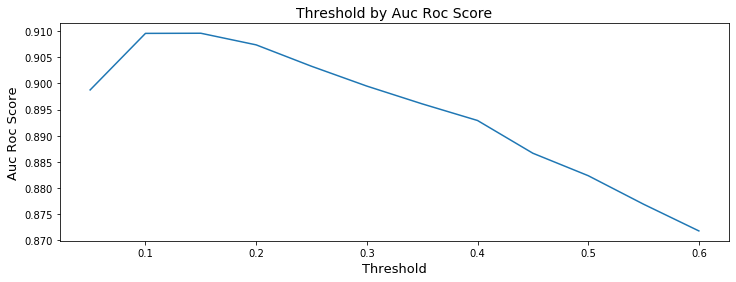

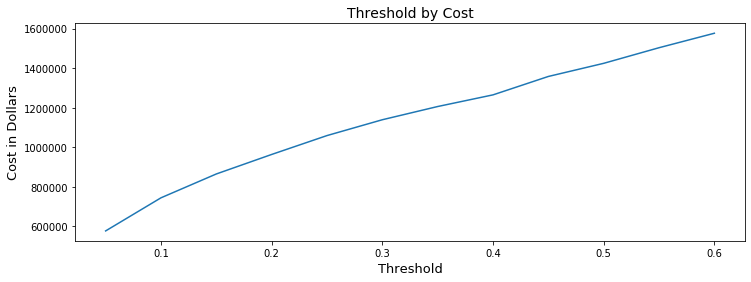

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.15 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn    fp
0        0.05       0.898752      577480  141  7724
1        0.10       0.909569      744720  219  4386
2        0.15       0.909595      865200  268  3060
3        0.20       0.907373      963740  306  2287
4        0.25       0.903281     1059160  341  1808
5        0.30       0.899488     1139140  370  1457
6        0.35       0.896089     1205920  394  1196
7        0.40       0.892911     1264820  415   991
8        0.45       0.886650     1357800  447   840
9        0.50       0.882356     1424160  470   708
10       0.55       0.876903     1503000  497   600
11       0.60       0.871793     1576140  522   507

roc auc score: 0.9095947480122423 

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56945
           1       0.38      0.87      0.53      2109

    accuracy            

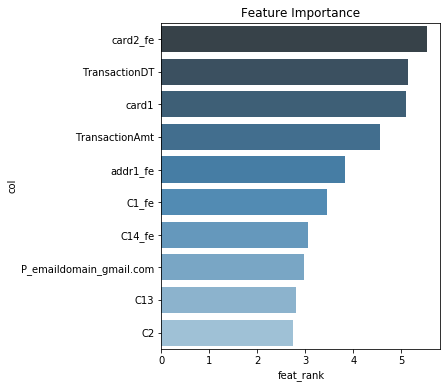

                        col  feat_rank
0                  card2_fe   5.538361
1             TransactionDT   5.134947
2                     card1   5.099596
3            TransactionAmt   4.556743
4                  addr1_fe   3.831154
5                     C1_fe   3.457373
6                    C14_fe   3.047184
7   P_emaildomain_gmail.com   2.967048
8                       C13   2.813848
9                        C2   2.741855
10                     M6_T   2.629304
11                    card5   2.182030
12               card4_visa   1.921240
13              ProductCD_W   1.887230
14                  V306_fe   1.680758
15             card6_credit   1.657129
16                  V317_fe   1.656583
17                  V279_fe   1.606132
18                       C6   1.496205
19                      C11   1.418156


In [13]:
#current, then test with "missing" value 
# max_depth = 10
bool_predict_proba = True
bool_thres_cost = False
max_depth = [9,10,11,12,13]
for val in max_depth:
    model_current = CatBoostClassifier(random_state=42, max_depth=val, verbose=0)
    mod.create_df_score_model(model_current)

In [ ]:
# base CatBoostClassifier
bool_predict_proba = True
model_current = CatBoostClassifier(
                                   iterations=300, 
                                   bagging_temperature=1e-3, 
                                   bootstrap_type='Bayesian', 
                                   boosting_type='Plain',
                                   colsample_bylevel=.1, 
                                   subsample=.4,  
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

In [ ]:
# no bagging, baysian

model_current = CatBoostClassifier(
#                                    bootstrap_type='Bernoulli', R: 0.904748
    
                                   boosting_type='Plain', #R:0.904748, 5.98min, 
                                   colsample_bylevel=.3, #keep, reduces training time
#                                    subsample=.4, #0.905090 7.49
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

Fitting model:

roc auc score: 0.8750507308654367 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56945
           1       0.67      0.76      0.72      2109

    accuracy                           0.98     59054
   macro avg       0.83      0.88      0.85     59054
weighted avg       0.98      0.98      0.98     59054


df_scores:

      feat_tested   fn   fp  precision    recall  roc_auc_score  \
223  model score  500  742   0.684390  0.762921       0.874945   
224          NaN  640  971   0.602049  0.696539       0.839744   
225          NaN  500  755   0.680626  0.762921       0.874831   
226          NaN  489  774   0.676692  0.768137       0.877272   
0            NaN  498  784   0.672651  0.763869       0.875051   

     time_elapsed (min)    tn     tp  
223           46.300068  1609  56203  
224            5.697695  1469  55974  
225           31.219427  1609  56190  
226           33.618625  1620  56171  
0             1

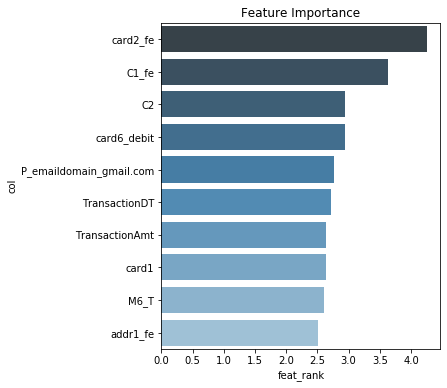

                        col  feat_rank
0                  card2_fe   4.259901
1                     C1_fe   3.640037
2                        C2   2.947682
3               card6_debit   2.944541
4   P_emaildomain_gmail.com   2.768790
5             TransactionDT   2.721803
6            TransactionAmt   2.642148
7                     card1   2.637849
8                      M6_T   2.608143
9                  addr1_fe   2.514183
10                   C14_fe   2.407720
11                      C13   2.338259
12                     V280   2.253850
13               card4_visa   2.191980
14         card4_mastercard   2.120391
15              ProductCD_W   2.083186
16                  V306_fe   1.983042
17                     V291   1.675853
18                      V12   1.659627
19                       C6   1.627289


In [34]:
# no bagging, baysian

model_current = CatBoostClassifier(
#                                    bootstrap_type='Bernoulli', R: 0.904748
    
                                   boosting_type='Plain', #R:0.904748, 5.98min, 
                                   colsample_bylevel=.4, #keep, reduces training time
#                                    subsample=.4, #0.905090 7.49
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

Fitting model:

roc auc score: 0.8747521805393899 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56945
           1       0.68      0.76      0.72      2109

    accuracy                           0.98     59054
   macro avg       0.83      0.87      0.85     59054
weighted avg       0.98      0.98      0.98     59054


df_scores:

     feat_tested   fn   fp  precision    recall  roc_auc_score  \
224         NaN  640  971   0.602049  0.696539       0.839744   
225         NaN  500  755   0.680626  0.762921       0.874831   
226         NaN  489  774   0.676692  0.768137       0.877272   
227         NaN  498  784   0.672651  0.763869       0.875051   
0           NaN  500  764   0.678045  0.762921       0.874752   

     time_elapsed (min)    tn     tp  
224            5.697695  1469  55974  
225           31.219427  1609  56190  
226           33.618625  1620  56171  
227           10.905158  1611  56161  
0             12.2171

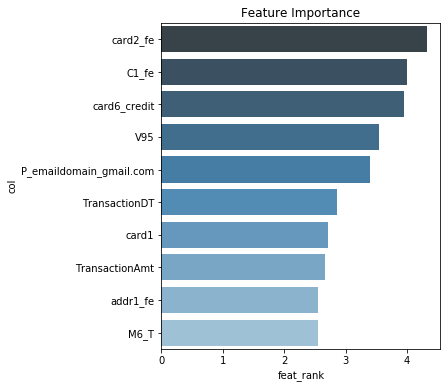

                        col  feat_rank
0                  card2_fe   4.325616
1                     C1_fe   3.992234
2              card6_credit   3.944567
3                       V95   3.539953
4   P_emaildomain_gmail.com   3.394699
5             TransactionDT   2.857815
6                     card1   2.716591
7            TransactionAmt   2.669488
8                  addr1_fe   2.553286
9                      M6_T   2.548785
10                      C13   2.439742
11                   C14_fe   2.435040
12                      V97   2.151525
13                       C2   2.069908
14               card4_visa   1.928373
15                  V306_fe   1.896566
16         card4_mastercard   1.854627
17                      C11   1.721101
18                      V12   1.508778
19                      V53   1.507201


In [35]:
# no bagging, baysian

model_current = CatBoostClassifier(
#                                    bootstrap_type='Bernoulli', R: 0.904748
    
                                   boosting_type='Plain', #R:0.904748, 5.98min, 
                                   colsample_bylevel=.5, #keep, reduces training time
#                                    subsample=.4, #0.905090 7.49
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

Fitting model:

roc auc score: 0.8772722475468892 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56945
           1       0.68      0.77      0.72      2109

    accuracy                           0.98     59054
   macro avg       0.83      0.88      0.85     59054
weighted avg       0.98      0.98      0.98     59054


df_scores:

     feat_tested   fn   fp  precision    recall  roc_auc_score  \
225         NaN  500  755   0.680626  0.762921       0.874831   
226         NaN  489  774   0.676692  0.768137       0.877272   
227         NaN  498  784   0.672651  0.763869       0.875051   
228         NaN  500  764   0.678045  0.762921       0.874752   
0           NaN  489  774   0.676692  0.768137       0.877272   

     time_elapsed (min)    tn     tp  
225           31.219427  1609  56190  
226           33.618625  1620  56171  
227           10.905158  1611  56161  
228           12.217110  1609  56181  
0             34.5302

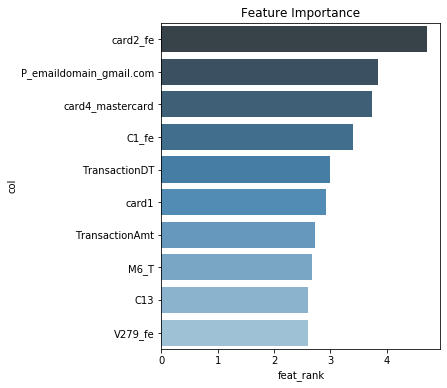

                        col  feat_rank
0                  card2_fe   4.721289
1   P_emaildomain_gmail.com   3.841173
2          card4_mastercard   3.734478
3                     C1_fe   3.412337
4             TransactionDT   2.991233
5                     card1   2.928217
6            TransactionAmt   2.734303
7                      M6_T   2.672296
8                       C13   2.606553
9                   V279_fe   2.598352
10                   C14_fe   2.570790
11              ProductCD_W   2.512355
12                 addr1_fe   2.468201
13                       C2   2.268566
14             card6_credit   2.141023
15                  V306_fe   2.132419
16                 card6_fe   1.908333
17                      V97   1.879282
18                     V128   1.683833
19                      C11   1.517001


In [36]:
# no bagging, baysian

model_current = CatBoostClassifier(
#                                    bootstrap_type='Bernoulli', R: 0.904748
    
                                   boosting_type='Plain', #R:0.904748, 5.98min, 
                                   colsample_bylevel=.99, #keep, reduces training time
#                                    subsample=.4, #0.905090 7.49
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

Fitting model:

roc auc score: 0.8748312041586715 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56945
           1       0.68      0.76      0.72      2109

    accuracy                           0.98     59054
   macro avg       0.84      0.87      0.85     59054
weighted avg       0.98      0.98      0.98     59054


df_scores:

      feat_tested   fn   fp  precision    recall  roc_auc_score  \
221  model score  482  773   0.677917  0.771456       0.878941   
222  model score  500  756   0.680338  0.762921       0.874822   
223  model score  500  742   0.684390  0.762921       0.874945   
224          NaN  640  971   0.602049  0.696539       0.839744   
0            NaN  500  755   0.680626  0.762921       0.874831   

     time_elapsed (min)    tn     tp  
221           26.526832  1627  56172  
222           23.418415  1609  56189  
223           46.300068  1609  56203  
224            5.697695  1469  55974  
0             3

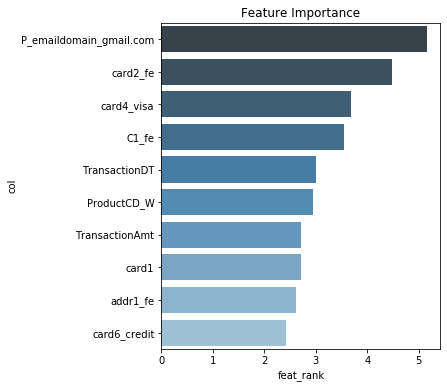

                        col  feat_rank
0   P_emaildomain_gmail.com   5.162478
1                  card2_fe   4.480724
2                card4_visa   3.675941
3                     C1_fe   3.555260
4             TransactionDT   2.993635
5               ProductCD_W   2.942631
6            TransactionAmt   2.717743
7                     card1   2.705408
8                  addr1_fe   2.615191
9              card6_credit   2.428849
10                   C14_fe   2.393734
11                     M6_T   2.328132
12                      C13   2.307301
13                  V306_fe   2.286215
14         card4_mastercard   2.096860
15                      C11   1.895403
16                  V279_fe   1.848713
17                       C2   1.780492
18                      V95   1.596698
19                      V97   1.397030


In [32]:
# no bagging, baysian

model_current = CatBoostClassifier(
#                                    bootstrap_type='Bernoulli', R: 0.904748
    
                                   boosting_type='Plain', #R:0.904748, 5.98min, 
                                   colsample_bylevel=.9, #keep, reduces training time
#                                    subsample=.4, #0.905090 7.49
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

Fitting model:

roc auc score: 0.8397435514732444 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     56945
           1       0.60      0.70      0.65      2109

    accuracy                           0.97     59054
   macro avg       0.80      0.84      0.82     59054
weighted avg       0.97      0.97      0.97     59054


df_scores:

      feat_tested   fn    fp  precision    recall  roc_auc_score  \
220          NaN  316  4575   0.281564  0.850166       0.884913   
221  model score  482   773   0.677917  0.771456       0.878941   
222  model score  500   756   0.680338  0.762921       0.874822   
223  model score  500   742   0.684390  0.762921       0.874945   
0            NaN  640   971   0.602049  0.696539       0.839744   

     time_elapsed (min)    tn     tp  
220            3.934398  1793  52370  
221           26.526832  1627  56172  
222           23.418415  1609  56189  
223           46.300068  1609  56203  
0        

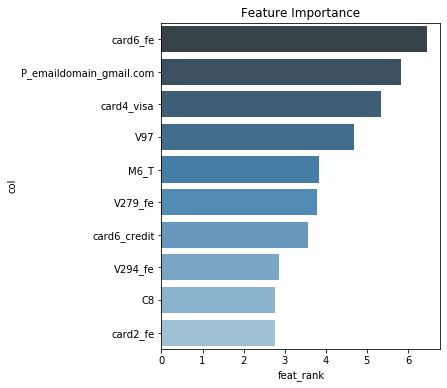

                        col  feat_rank
0                  card6_fe   6.467999
1   P_emaildomain_gmail.com   5.839304
2                card4_visa   5.356216
3                       V97   4.689775
4                      M6_T   3.840866
5                   V279_fe   3.782978
6              card6_credit   3.562657
7                   V294_fe   2.853342
8                        C8   2.768678
9                  card2_fe   2.767283
10                    C1_fe   2.735527
11                  V306_fe   2.587147
12              ProductCD_W   2.398244
13                   C14_fe   2.171840
14                     V308   1.952102
15                      V54   1.848789
16                      V53   1.708855
17                      C13   1.586240
18                     M3_T   1.563645
19                       C2   1.546923


In [31]:
# CatBoostClassifier not tuned
model_current = CatBoostClassifier(
#                                    bootstrap_type='Bernoulli', R: 0.904748
    
#                                    boosting_type='Plain', #R:0.904748, 5.98min, 
#                                    colsample_bylevel=.6, #keep, reduces training time
                                   subsample=.4, #0.905090 7.49
#                                    max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

Fitting model:

roc auc score: 0.8798976710534955 


The following new features have been created: ['addr1_fe', 'addr2_fe', 'card2_fe', 'card3_fe', 'C1_fe', 'P_emaildomain_fe', 'card6_fe', 'V294_fe', 'V279_fe', 'C14_fe', 'V306_fe', 'D2_fe', 'D10_fe', 'card5_fe', 'V317_fe', 'V69_fe', 'D1_fe', 'D3_fe', 'D4_fe', 'D11_fe'] 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56945
           1       0.69      0.77      0.73      2109

    accuracy                           0.98     59054
   macro avg       0.84      0.88      0.86     59054
weighted avg       0.98      0.98      0.98     59054


df_scores:

      feat_tested   fn    fp  precision    recall  roc_auc_score  \
242          NaN  446  8632   0.161535  0.788525       0.818470   
243          NaN  241  3873   0.325379  0.885728       0.908857   
244  model score  475   719   0.694433  0.774775       0.881074   
245  model score  468   719   0.695339  0.778094       0.882734   
0

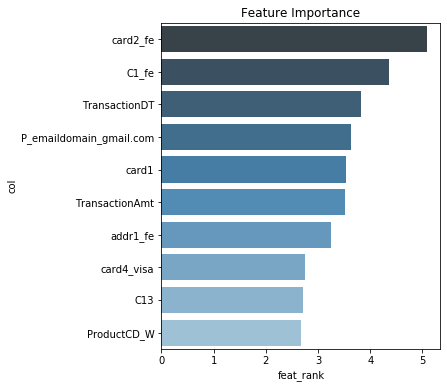

                        col  feat_rank
0                  card2_fe   5.090486
1                     C1_fe   4.360170
2             TransactionDT   3.822162
3   P_emaildomain_gmail.com   3.627714
4                     card1   3.533173
5            TransactionAmt   3.510213
6                  addr1_fe   3.242436
7                card4_visa   2.759363
8                       C13   2.718165
9               ProductCD_W   2.677648
10                   C14_fe   2.626039
11                     M6_T   2.583325
12                      V97   2.345029
13                  V279_fe   2.022233
14                       C2   1.971653
15                 card6_fe   1.690475
16                  V306_fe   1.686144
17                  V294_fe   1.682512
18                  V317_fe   1.653701
19                    card5   1.612470


In [304]:
# CatBoostClassifier TUNED
bool_predict_proba=True
model_current = CatBoostClassifier(
                                   max_depth=11,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)


In [ ]:
# no bagging, baysian

model_current = CatBoostClassifier(
#                                    bootstrap_type='Bernoulli', R: 0.904748
    
#                                    boosting_type='Plain', #R:0.904748, 5.98min, 
                                   colsample_bylevel=.7, #keep, reduces training time
#                                    subsample=.4, #0.905090 7.49
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

In [ ]:
# no bagging, baysian

model_current = CatBoostClassifier(
#                                    bootstrap_type='Bernoulli', R: 0.904748
    
                                   boosting_type='Plain', #R:0.904748, 5.98min, 
                                   colsample_bylevel=.8, #keep, reduces training time
#                                    subsample=.4, #0.905090 7.49
                                   max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)

## Model Tuning

In [ ]:
### Tuning XGBClassifier READY ###
print('tuning xgbc')
xgbc = XGBClassifier(n_jobs=-1, random_state=42)

max_depth = [2,3,5,7,9,11,13]
# learning_rate = [0,.1,.3,.5,.7,.9]
booster = ['gbtree', 'gblinear', 'dart']
subsample = [.1,.3,.5,.7]
colsample_bytree = [.1,.3,.5,.7]
colsample_bylevel = [0,.1,.3,.5,.7,.9,1]
colsample_bynode = [.1,.3,.5,.7]
reg_alpha = [0,1,3,5,7]
reg_lambda = [1,3,5,7]
scale_pos_weight = [1,3,5,7]
base_score = [.1,.2,.3,.4,.5]

hyperparameters = dict(max_depth=max_depth, 
#                        learning_rate=learning_rate, 
                       booster=booster, 
                       subsample=subsample, 
                       colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, 
                       colsample_bynode=colsample_bynode, reg_alpha=reg_alpha, reg_lambda=reg_lambda, 
                       scale_pos_weight=scale_pos_weight,
                       base_score=base_score
                      )

clf = RandomizedSearchCV(xgbc, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best booster:', best_model.best_estimator_.get_params()['booster'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print('Best colsample_bytree:', best_model.best_estimator_.get_params()['colsample_bytree'])
print('Best colsample_bylevel:', best_model.best_estimator_.get_params()['colsample_bylevel'])
print('Best colsample_bynode:', best_model.best_estimator_.get_params()['colsample_bynode'])
print('Best reg_alpha:', best_model.best_estimator_.get_params()['reg_alpha'])
print('Best reg_lambda:', best_model.best_estimator_.get_params()['reg_lambda'])
print('Best scale_pos_weight:', best_model.best_estimator_.get_params()['scale_pos_weight'])
print('Best base_score:', best_model.best_estimator_.get_params()['base_score'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [ ]:
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)

In [ ]:
###### testing manual tuning ######
### manual xbgc tuning
max_depth = [3,5,7,9,11,13,15]
# max_depth = [1,3,5]
list_time_elapsed = []
list_roc_auc_score = []
for val in max_depth:
    model_xgbc = XGBClassifier(max_depth=val, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    model_xgbc.fit(mod.X_train_test, mod.y_train)
    y_pred_xgbc = model_xgbc.predict(mod.X_test)
    elapsed_time = (time.time() - start_time) / 60
    
    score_roc_auc = roc_auc_score(mod.y_test, y_pred_xgbc)

    list_time_elapsed.append(elapsed_time)
    list_roc_auc_score.append(score_roc_auc)
    print('max depth: ', val)
    print(confusion_matrix(mod.y_test, y_pred_xgbc))

col_time_elapsed = pd.Series(list_time_elapsed)
col_roc_score = pd.Series(list_roc_auc_score)
col_max_depth = pd.Series(max_depth)
df_results_xgbc = pd.concat([col_max_depth, col_roc_score,col_time_elapsed], 
                            keys=['max_depth', 'roc_auc_score', 'time_elap'], 
                            axis=1)
print(df_results_xgbc)

sns.lineplot(x='max_depth', y='roc_auc_score', data=df_results_xgbc)
plt.title("XGBC manual tuning")
plt.show()

In [ ]:
#### Tuning RandomForestClassifier READY ####
rfc = RandomForestClassifier(oob_score=False, n_jobs=1, random_state=42, verbose=1)

n_estimators = [50,75,100,125,150,200]
criterion = ['gini', 'entropy']
max_depth = [3,5,7,9,11,13,15]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,2,4,6,8,10]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [2,3,5,7,9,None]
min_impurity_decrease = [0,.1,.3,.5,.7,.9]

hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                       min_impurity_decrease=min_impurity_decrease
                      )

clf = RandomizedSearchCV(rfc, hyperparameters, random_state=42, cv=5, verbose=5, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes'])
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [ ]:
#### LR Tuning ####
lr = LogisticRegression(random_state=42, n_jobs=-1)

penalty = ['l1', 'l2', 'elasticnet','none']
tol = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
C = [1e-1,.2,.3,.5,.7,1]
fit_intercept = [True,False]
intercept_scaling = [1,.1,.01,.001]
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'sag']#, 'liblinear','saga']
max_iter = [50,75,100,150,200]
multi_class = ['auto', 'ovr', 'multinomial']
l1_ratio = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]


hyperparameters = dict(penalty=penalty, 
#                        tol=tol, 
#                        C=C, 
#                        fit_intercept=fit_intercept,
                       intercept_scaling=intercept_scaling, 
                       class_weight=class_weight,
                       solver=solver, 
#                        max_iter=max_iter
                       multi_class=multi_class, 
                       l1_ratio=l1_ratio
                      )

clf = RandomizedSearchCV(lr, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)
# best_model = clf.fit(mod.X_features_test, mod.y_target_test) #testing

# best hyper parameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best tol:', best_model.best_estimator_.get_params()['tol'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best fit_intercept:', best_model.best_estimator_.get_params()['fit_intercept'])
print('Best intercept_scaling:', best_model.best_estimator_.get_params()['intercept_scaling'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Best multi_class:', best_model.best_estimator_.get_params()['multi_class'])
print('Best l1_ratio:', best_model.best_estimator_.get_params()['l1_ratio'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [ ]:
#### Tuning DTC READY ####
dt = DecisionTreeClassifier(random_state=42, n_jobs=-1)

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3,5,7,9,11]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,3,5,7,9]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
class_weight = ['balanced', None]

hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, 
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, class_weight=class_weight
                      )

clf = RandomizedSearchCV(dt, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)
# best_model = clf.fit(mod.X_features_test, mod.y_target_test) #testing
 
# best hyper parameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [ ]:
### Tuning CatBoost READY ###
# Tune learning rate manually.
cbc = CatBoostClassifier(random_state=42)

max_depth = [2,3,5,7,9,11,13]
learning_rate = [.1,.3,.5,.7,.9]
# bagging_temperature = []
subsample = [1,3,5,7]
n_estimators = [50,75,100,150]
depth = [2,4,6,8,10]
grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']


hyperparameters = dict(
#                         max_depth=max_depth, 
#                        learning_rate=learning_rate, 
#                        n_estimators=n_estimators,
                       subsample=subsample,
#                        depth=depth,
                       grow_policy=grow_policy
                      )

clf = RandomizedSearchCV(cbc, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)



In [ ]:
df_temp_read = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
df_temp_read = df_temp_read.drop('Unnamed: 0', axis=1)
# df_temp_read[len(df_temp_read)-40:]
df_temp_read